In [13]:
import os
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pingouin as pg
from pathlib  import Path

counts_df_diagnosis = pd.read_csv('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/vox/NPM_comparisons/counts_per_diagnosis_affective_only.csv', usecols = ('gad','ptsd','sad', 'ocd'))
counts_df = pd.read_csv('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/vox/NPM_comparisons/counts_hist_affective_only.csv')
counts_df_diagnosis = counts_df_diagnosis.rename(columns={'gad': 'GAD', 'ptsd': 'PTSD', 'sad': 'SAD', 'ocd': 'OCD'})
print(counts_df_diagnosis)
print(counts_df)

      GAD      OCD    PTSD     SAD
0   750.0  16216.0   178.0  8166.0
1   746.0    720.0   272.0   288.0
2   640.0    158.0    53.0   388.0
3   263.0    630.0  1241.0   625.0
4   168.0  13253.0   912.0  8275.0
..    ...      ...     ...     ...
95    NaN      NaN     NaN     NaN
96    NaN      NaN     NaN     NaN
97    NaN      NaN     NaN     NaN
98    NaN      NaN     NaN     NaN
99    NaN      NaN     NaN     NaN

[100 rows x 4 columns]
     reference_counts  control_counts  clinical_counts
0                 765           557.0            750.0
1                 378           731.0            746.0
2                 866          1918.0            640.0
3                7490          1672.0            263.0
4                1379           444.0            168.0
..                ...             ...              ...
641              1102             NaN              NaN
642             12209             NaN              NaN
643               152             NaN              NaN
644   

In [15]:
# Rename the columns in counts_df first
counts_df = counts_df.rename(columns={
    'reference_counts': 'Control \nTest',
    'control_counts': 'Clinical \nTest \nControls',
    'clinical_counts': 'Clinical \nTest \nPatients'
})

# Combine 'Control \nTest' and 'Clinical \nTest \nControls'
control_test = counts_df['Control \nTest']
clinical_test_controls = counts_df['Clinical \nTest \nControls']
combined_control_test = pd.concat([control_test, clinical_test_controls]).reset_index(drop=True)

# Create a new DataFrame for the combined 'Control \nTest' column
combined_control_test_df = pd.DataFrame({'Unaffected \nControls': combined_control_test})

# Keep the 'Clinical \nTest \nPatients' column and rename it to 'Patients'
patients_df = pd.DataFrame({'Patients\n with an \naffective \ncondition': counts_df['Clinical \nTest \nPatients']}).reset_index(drop=True)

# Concatenate the combined 'Control \nTest', 'Patients', and 'counts_df_diagnosis'
concatenated_df = pd.concat([combined_control_test_df, patients_df, counts_df_diagnosis.reset_index(drop=True)], axis=1)

# Define the correct column order for diagnoses and the labels for other columns
new_order = ['Unaffected \nControls', 'Patients\n with an \naffective \ncondition', 'PTSD', 'GAD', 'SAD', 'OCD']

# Reorder the DataFrame columns based on the new order
concatenated_df = concatenated_df[new_order]

# Display the resulting DataFrame
print(concatenated_df)

      Unaffected \nControls  Patients\n with an \naffective \ncondition  \
0                     765.0                                       750.0   
1                     378.0                                       746.0   
2                     866.0                                       640.0   
3                    7490.0                                       263.0   
4                    1379.0                                       168.0   
...                     ...                                         ...   
1287                    NaN                                         NaN   
1288                    NaN                                         NaN   
1289                    NaN                                         NaN   
1290                    NaN                                         NaN   
1291                    NaN                                         NaN   

        PTSD    GAD     SAD      OCD  
0      178.0  750.0  8166.0  16216.0  
1      272.0  746.0  

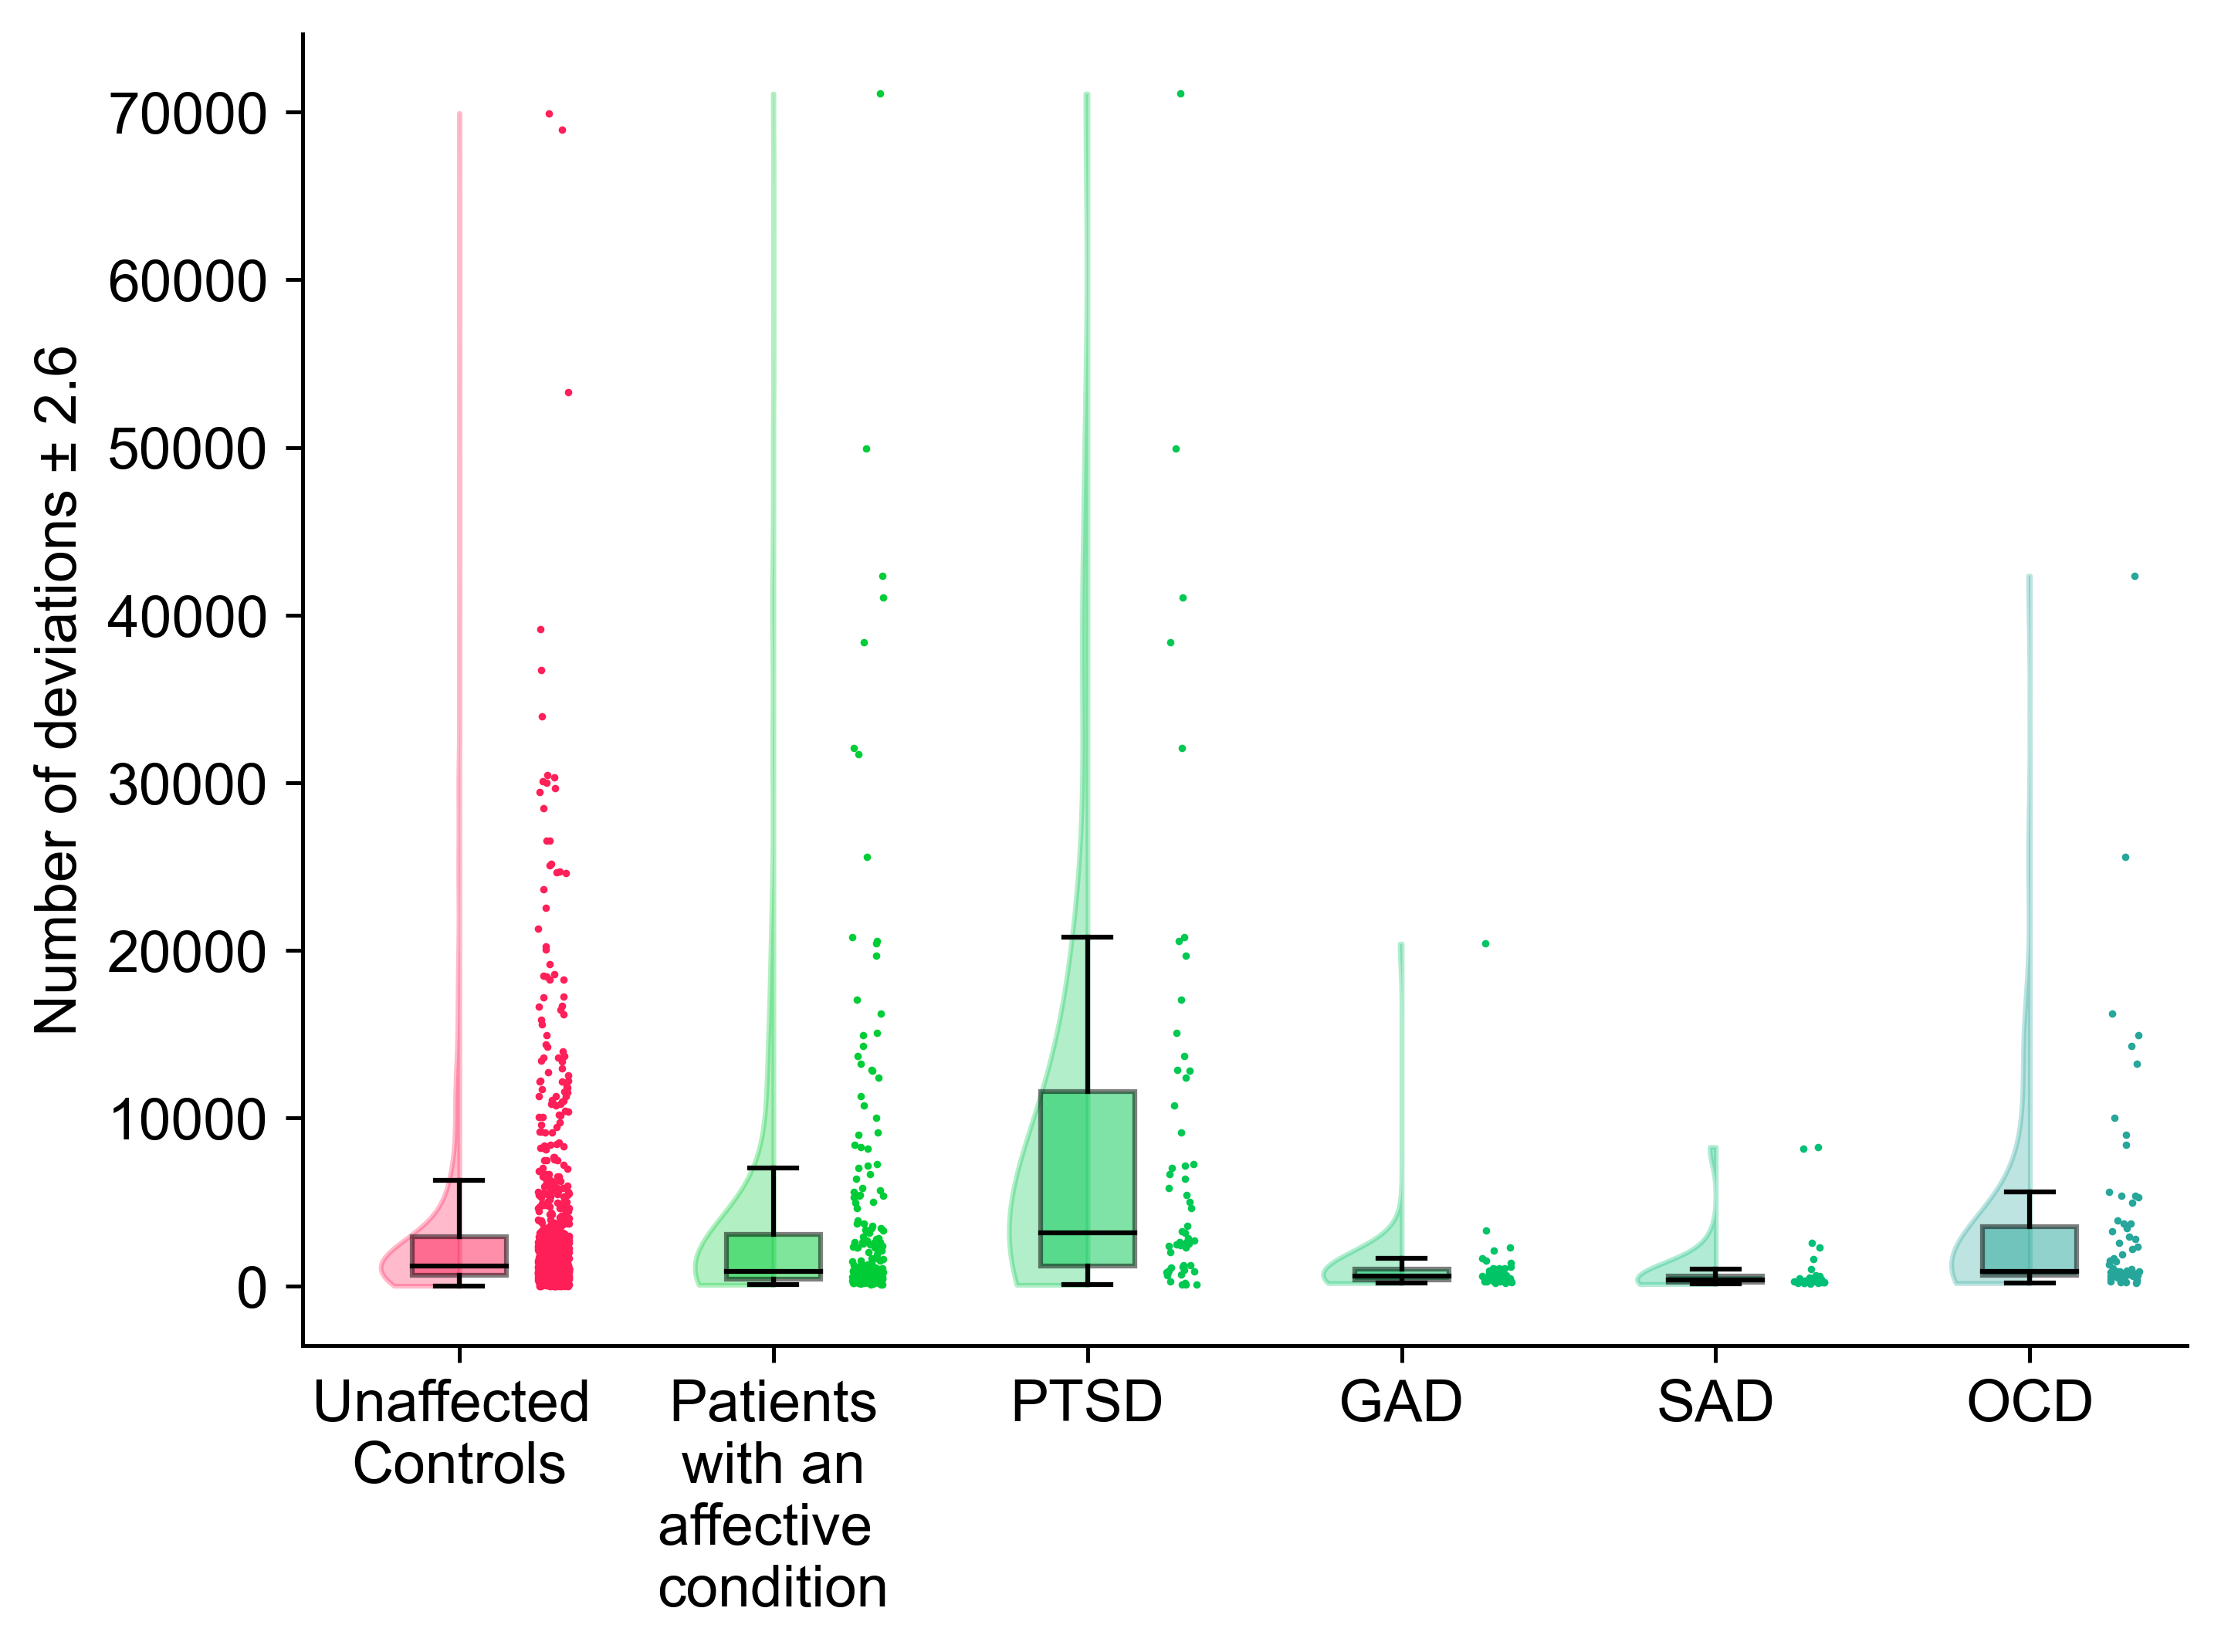

In [16]:
# Create a list of colors for the boxplots based on the number of diagnoses you have
col_colours = ['#FF1F58', '#00CD36', '#00c851', '#00c465', '#00bf76', '#26a69a']
#col_colours.reverse()

# Assuming your data is organized such that the first set of columns are the counts_df data
# and the remaining columns correspond to diagnoses
data_x = [concatenated_df[feature].dropna().values for feature in concatenated_df.columns]

# Plotting
plt.rcParams['figure.dpi'] = 450
fpath = Path(mpl.get_data_path(), "/project_cephfs/3022017.06/ENIGMA_ANX/arial.ttf")
fig, ax = plt.subplots(figsize=(7, 5))
plt.rcParams.update({'font.size': 12})

# Boxplot data
bp = ax.boxplot(data_x, patch_artist=True, showfliers = False, widths = 0.3, medianprops=dict(color='black'))

# Change boxplot colors
for patch, color in zip(bp['boxes'], col_colours):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_alpha(0.5)

# Violinplot data
vp = ax.violinplot(data_x, points=500, showmeans=False, showextrema=False, showmedians=False)

# Modify violinplot
for idx, b in enumerate(vp['bodies']):
    m = np.mean(b.get_paths()[0].vertices[:, 0])  # Compute the mean of x-coordinates
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)  # Clip x-coordinates to the left side
    b.set_color(col_colours[idx])

# Scatterplot data
for idx, features in enumerate(data_x):
    x = np.full(len(features), idx + .8)
    idxs = np.arange(len(x))
    out = x.astype(float)
    out.flat[idxs] += np.random.uniform(low=-.05, high=.05, size=len(idxs))
    x = out+0.5
    plt.scatter(x, features, s=.3, c=col_colours[idx])
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(np.arange(1, len(concatenated_df.columns) + 1), concatenated_df.columns, font = fpath)  # Set text labels and rotate
plt.ylabel('Number of deviations ± 2.6', font = fpath)
plt.yticks(font = fpath)
#plt.ylim(0,70000)
plt.show()

fig.savefig('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/plots/deviation_count_control_clincial_boxplot_all_combined_controls_affective_only.png', dpi=300)



Separate test controls and clnical test controls

In [5]:
# Define the excluded columns and diagnoses
diagnoses = ['PTSD', 'GAD', 'SAD', 'OCD'] #'MDD', 'Panic \nDisorder','Specific \nPhobia'] 'Schizophrenia', 'Other']

group_names = ['Control \nTest', 'Clinical \nTest \nControls', 'Clinical \nTest \nPatients']
# Exclude columns from counts_df_diagnosis
#counts_df_diagnosis = counts_df_diagnosis.drop(columns=excluded_columns)

# Concatenate the DataFrames
concatenated_df = pd.concat([counts_df, counts_df_diagnosis, ], axis=1)

# Define the diagnoses as column headings
column_headings = group_names + diagnoses

# Assign the column headings to the concatenated DataFrame
concatenated_df.columns = column_headings

# Reorder the columns of the concatenated DataFrame
new_order = ['Control \nTest', 'Clinical \nTest \nControls', 'Clinical \nTest \nPatients', 'PTSD', 'GAD', 'SAD', 'OCD']
concatenated_df = concatenated_df[new_order]

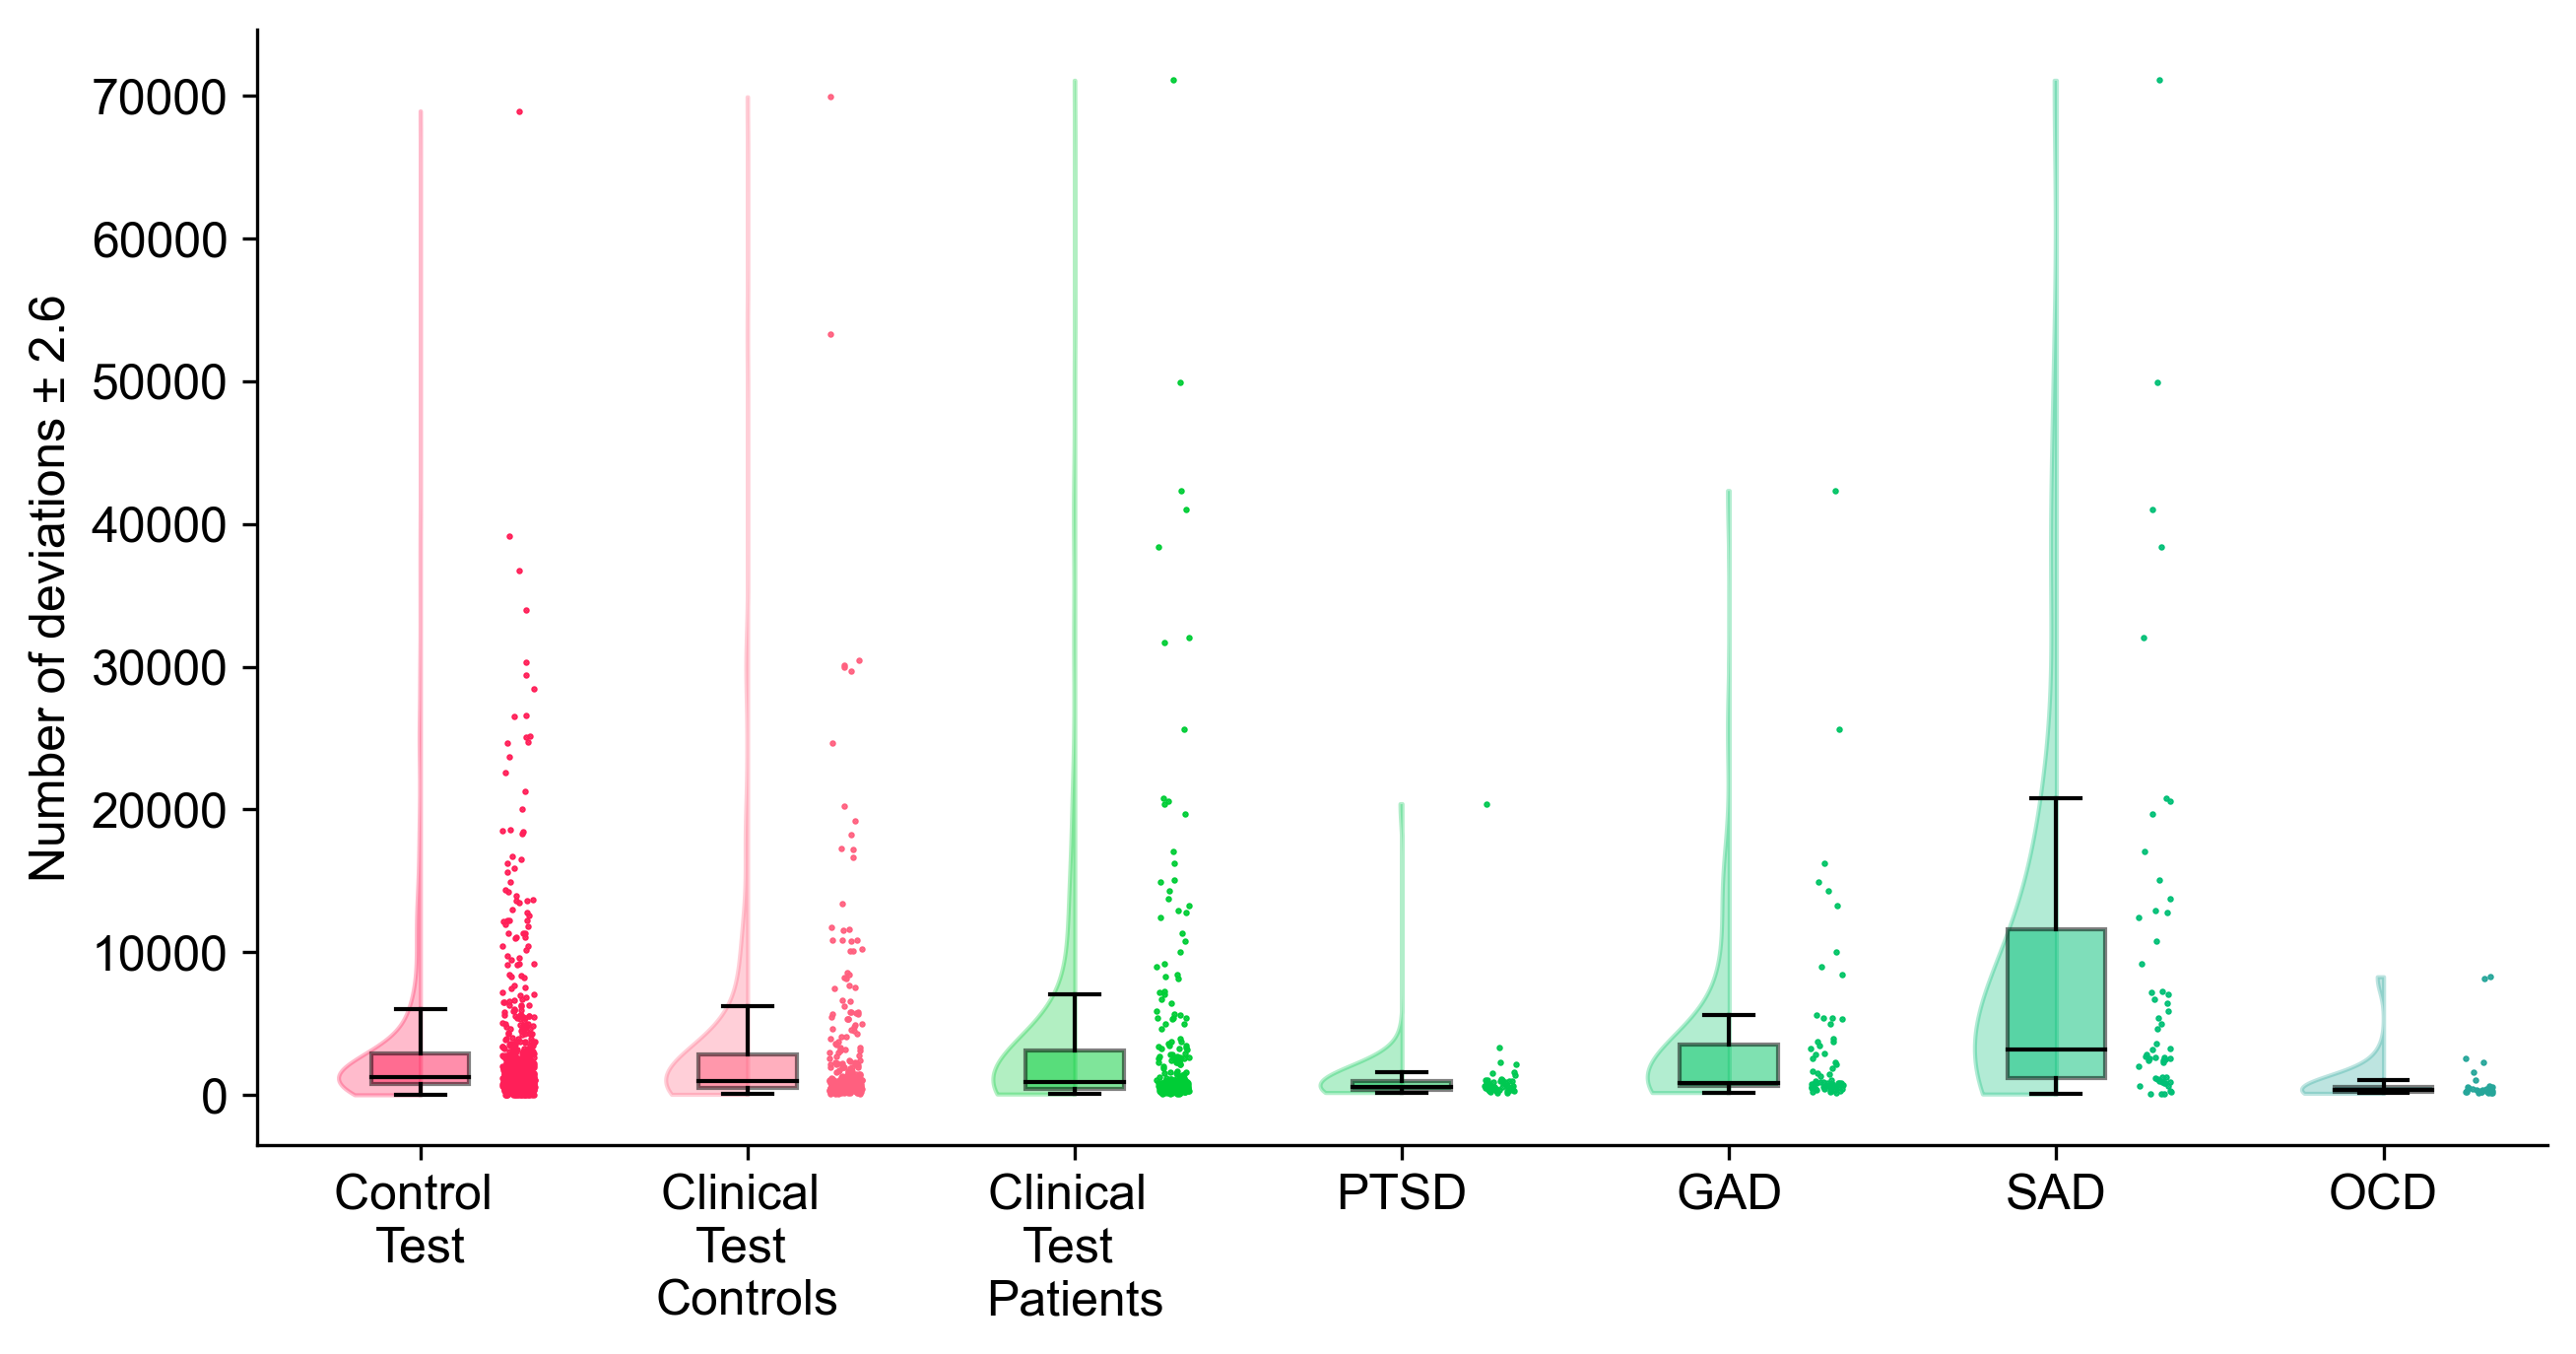

In [6]:
# Create a list of colors for the boxplots based on the number of diagnoses you have
col_colours = ['#FF1F58', '#FF607F', '#00CD36', '#00c851', '#00c465', '#00bf76', '#26a69a']
#col_colours.reverse()

# Assuming your data is organized such that the first set of columns are the counts_df data
# and the remaining columns correspond to diagnoses
data_x = [concatenated_df[feature].dropna().values for feature in concatenated_df.columns]

# Plotting
plt.rcParams['figure.dpi'] = 300
fpath = Path(mpl.get_data_path(), "/project_cephfs/3022017.06/ENIGMA_ANX/arial.ttf")
fig, ax = plt.subplots(figsize=(10, 5))

# Boxplot data
bp = ax.boxplot(data_x, patch_artist=True, showfliers = False, widths = 0.3, medianprops=dict(color='black'))

# Change boxplot colors
for patch, color in zip(bp['boxes'], col_colours):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_alpha(0.5)

# Violinplot data
vp = ax.violinplot(data_x, points=500, showmeans=False, showextrema=False, showmedians=False)

# Modify violinplot
for idx, b in enumerate(vp['bodies']):
    m = np.mean(b.get_paths()[0].vertices[:, 0])  # Compute the mean of x-coordinates
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)  # Clip x-coordinates to the left side
    b.set_color(col_colours[idx])

# Scatterplot data
for idx, features in enumerate(data_x):
    x = np.full(len(features), idx + .8)
    idxs = np.arange(len(x))
    out = x.astype(float)
    out.flat[idxs] += np.random.uniform(low=-.05, high=.05, size=len(idxs))
    x = out+0.5
    plt.scatter(x, features, s=.3, c=col_colours[idx])
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(np.arange(1, len(concatenated_df.columns) + 1), concatenated_df.columns, font = fpath)  # Set text labels and rotate
plt.ylabel('Number of deviations ± 2.6', font = fpath)
plt.yticks(font = fpath)
#plt.ylim(0,70000)
plt.show()

fig.savefig('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/plots/deviation_count_control_clincial_boxplot_all_affective_only.png', dpi=300)

